In [1]:
# from PIL import Image
from PIL import Image, ImageOps
import os, glob
import numpy as np
from sklearn import model_selection #cross_validation
# from keras.utils import np_utils

# General imports
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from pylab import cm
import warnings

In [2]:
# input
classes = ["g", "h"]

In [3]:
# image size of 28 x 28
image_size = 28
# image_size = 8
# Maximum number of sheets to read
max_read = 20

In [4]:
num_classes = len(classes)

In [5]:
# load the image
X = []
Y = []
for index, classlabel in enumerate(classes):
    images_dir = "./images/" + classlabel
    files = glob.glob(images_dir + "/*.jpg")
    for i, file in enumerate(files):
        # Stop if you read more than max_read to make the number of sheets for each class
        if i >= max_read: break
        # open the file, read as data, add to X 
        # Repeatedly add labels with the same index to Y
        image = Image.open(file)
        image = ImageOps.invert(image)
        image = image.convert("L")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data)
        Y.append(index)

In [6]:
X = np.array(X)
Y = np.array(Y)

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
X_train = X_train.reshape(len(X_train), -1).astype(np.float64)
X_test = X_test.reshape(len(X_test), -1).astype(np.float64)

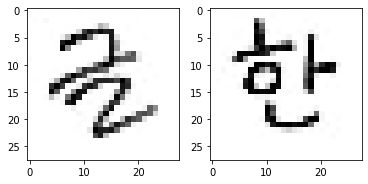

In [8]:
fig = plt.figure()

LABELS = [0, 1]
num_labels = len(LABELS)
for i in range(num_labels):
    ax = fig.add_subplot(1, num_labels, i+1)
    img = X[Y==LABELS[i]][0].reshape((28,28))
    ax.imshow(img, cmap="Greys")

In [9]:
print(Y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [10]:
print(X_train[0])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   6.   0.   0.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   8.   5.   0.   0.   0.
   0.   0.   0.   5.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   8.   0.   0.   0.   3.   0.
   0.   3.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  25.   0.   0.   0.
   0.   0.   4.   0.  66.  36.   0.   0.   2.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. 153. 203.  14.   0.   5.
   0.   0.   0.  55. 255. 174.  23.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. 225. 255.   6.   0.   0.
   0.   0.   6.  79. 243.  25.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0. 224. 248.   0.   0.   0.
   0.   0.   0.  94. 255.   0.   3.   6.   0.   1.   0.   0.   0.   0.
   0. 

In [11]:
warnings.filterwarnings("ignore")

# scikit-learn imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Qiskit imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [12]:
# Standardize
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
#sample_test = ss.transform(sample_test)

In [13]:
# Reduce dimensions
N_DIM = 5
pca = PCA(n_components=N_DIM)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [14]:
# Normalize
mms = MinMaxScaler((-1, 1))
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)
#sample_test = mms.transform(sample_test)

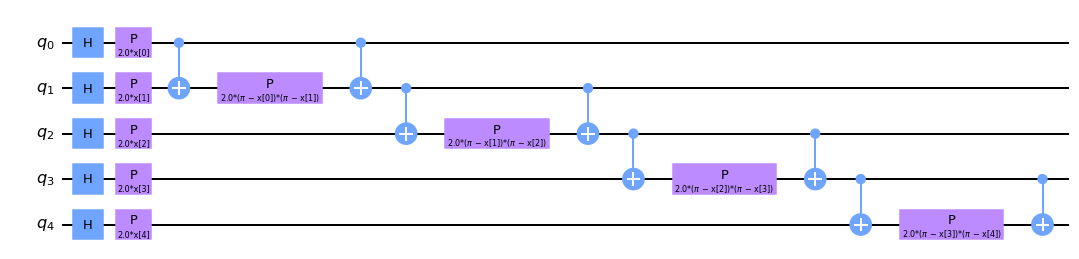

In [15]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=5, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

In [16]:
zz_kernel = QuantumKernel(feature_map=map_zz, quantum_instance=Aer.get_backend('statevector_simulator'))

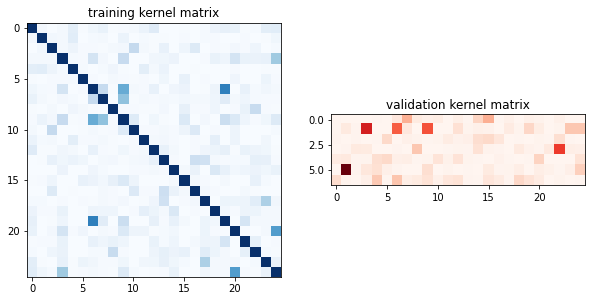

In [17]:
matrix_train = zz_kernel.evaluate(x_vec=X_train)
matrix_val = zz_kernel.evaluate(x_vec=X_test, y_vec=X_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_val),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("validation kernel matrix")
plt.show()

In [18]:
zz_svc = SVC(kernel='precomputed')
zz_svc.fit(matrix_train, y_train)
zz_score = zz_svc.score(matrix_val, y_test)

print(f'Precomputed kernel classification test score: {zz_score}')

Precomputed kernel classification test score: 1.0
